In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
from KMlib.metrics import total_score
from KMlib.plot_metrics import plot_loss,plot_test
from KMlib.naive_processing import get_submit_data
from KMlib.processing import pr_scaling,x_scaling,Processer,get_test_data

In [2]:
def get_r_model(train, valid,  epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides=1, padding="causal",activation="relu",input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True), 
    tf.keras.layers.LSTM(64, return_sequences=False),   
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,
                        validation_data=valid)
    return model, history
def get_p_model(train, valid,  epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides=1, padding="causal",activation="relu",input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True), 
    tf.keras.layers.LSTM(64, return_sequences=False),   
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,validation_data=valid)
    return model, history

In [3]:
# change file here
m = 'r_6'
df_rich = pd.read_csv(r'../data/the_rich_r_6.csv',index_col = 0)
df_poor = pd.read_csv(r'../data/the_poor_r_6.csv',index_col = 0)

In [4]:
## get true test value
df = pd.read_csv(r'../data/complete_feature.csv',index_col = 0)
purchase_true = df.loc["2014-08-02":"2014-08-31"].iloc[:, 0]
redeem_true = df.loc["2014-08-02":"2014-08-31"].iloc[:, 1]
df_train = df.loc[:"2014-08-01"]
# time_index = np.array(df.index) 


In [5]:
df_poor_train = df_poor.loc[:"2014-08-01"]
df_rich_train = df_rich.loc[:"2014-08-01"]
df_poor_train = df_poor.loc[:"2014-08-01"]
df_rich_train = df_rich.loc[:"2014-08-01"]
pp_data,prc_data,prt_data,pp_scaler,prc_scaler,prt_scaler = pr_scaling(df_poor_train)
rp_data,rrc_data,rrt_data,rp_scaler,rrc_scaler,rrt_scaler = pr_scaling(df_rich_train)


In [6]:
WINDOW_SIZE =14
BATCH_SIZE = 16
SHUFFLE_BUFFER = 100
number_pred = 30
number_shift = 7
input_dimension = 3
C= Processer(WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER,number_pred,number_shift,input_dimension)



In [7]:
# Train-Valid Split 
pp_train,pp_valid = C.train_valid_split(pp_data)
prc_train,prc_valid = C.train_valid_split(prc_data)
prt_train,prt_valid = C.train_valid_split(prc_data)
rp_train,rp_valid = C.train_valid_split(rp_data)
rrc_train,rrc_valid = C.train_valid_split(rrc_data)
rrt_train,rrt_valid = C.train_valid_split(rrc_data)

# test split
df_poor_test = df_poor_train[-WINDOW_SIZE:]
df_rich_test = df_rich_train[-WINDOW_SIZE:]
pp_test,prc_test,prt_test = get_test_data(df_poor_test,pp_scaler,prc_scaler,prt_scaler)
rp_test,rrc_test,rrt_test = get_test_data(df_rich_test,rp_scaler,rrc_scaler,rrt_scaler)

In [8]:
# poor
pp_tensor_train,pp_tensor_valid = C.get_tensor_dataset(pp_data)
prc_tensor_train,prc_tensor_valid = C.get_tensor_dataset(prc_data)
prt_tensor_train,prt_tensor_valid = C.get_tensor_dataset(prt_data)
## rich
rp_tensor_train,rp_tensor_valid = C.get_tensor_dataset(rp_data)
rrc_tensor_train,rrc_tensor_valid = C.get_tensor_dataset(rrc_data)
rrt_tensor_train,rrt_tensor_valid = C.get_tensor_dataset(rrt_data)

## Model developing part

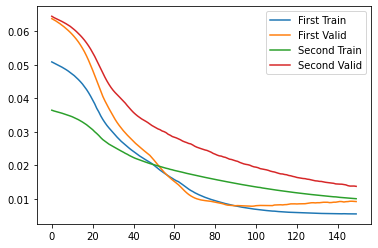

In [15]:
30# p
epochs = 150
pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = epochs)
rp_model,rp_history =get_p_model(rp_tensor_train ,pp_tensor_valid,epochs = epochs)
plot_loss(pp_history, rp_history)

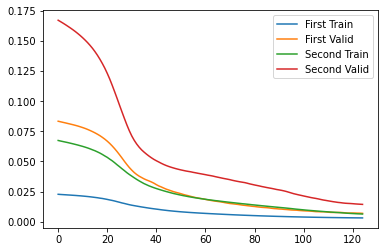

In [10]:
epochs = 125
prc_model,prc_history =get_r_model(prc_tensor_train,prc_tensor_valid,epochs = epochs)
prt_model,prt_history =get_r_model(prt_tensor_train,prt_tensor_valid,epochs = epochs)
plot_loss(prc_history,prt_history)

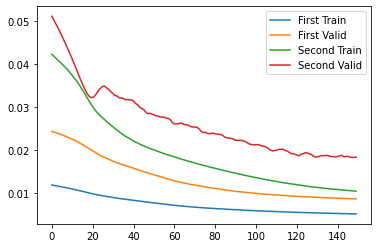

In [11]:
epochs = 150
rrc_model,rrc_history =get_r_model(rrc_tensor_train,rrc_tensor_valid,epochs = epochs)
rrt_model,rrt_history =get_r_model(rrt_tensor_train,rrt_tensor_valid,epochs =epochs)
plot_loss(rrc_history,rrt_history)

In [12]:
df_poor_test = df_poor[-WINDOW_SIZE:]
df_rich_test = df_rich[-WINDOW_SIZE:]
pp_test,prc_test,prt_test = get_test_data(df_poor_test,pp_scaler,prc_scaler,prt_scaler)
rp_test,rrc_test,rrt_test = get_test_data(df_rich_test,rp_scaler,rrc_scaler,rrt_scaler)

In [13]:
pp_pred = pp_scaler.inverse_transform(pp_model.predict(pp_test[np.newaxis,...])).reshape(30,)
prc_pred = prc_scaler.inverse_transform(prc_model.predict(prc_test[np.newaxis,...])).reshape(30,)
prt_pred = prt_scaler.inverse_transform(prt_model.predict(prt_test[np.newaxis,...])).reshape(30,)
rp_pred = rp_scaler.inverse_transform(rp_model.predict(rp_test[np.newaxis,...])).reshape(30,)
rrc_pred = rrc_scaler.inverse_transform(rrc_model.predict(rrc_test[np.newaxis,...])).reshape(30,)
rrt_pred = rrt_scaler.inverse_transform(rrt_model.predict(rrt_test[np.newaxis,...])).reshape(30,)

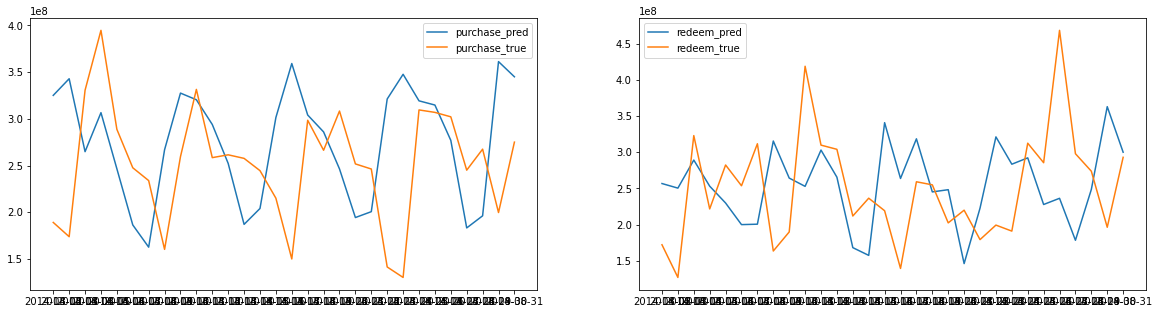

69.38156460423518

In [14]:
purchase_pred = pp_pred + rp_pred
redeem_pred = rrc_pred + rrt_pred + prt_pred + prc_pred
plot_test(purchase_pred,purchase_true,redeem_pred,redeem_true)
total_score(purchase_pred,purchase_true,redeem_pred,redeem_true)

In [ ]:
# WINDOW 14 SHIFT 30 BATCH 1 - 104
# Window 14 shift 7 batch 7 - 94


In [18]:
get_submit_data(purchase_pred,redeem_pred)

,0,1,2
0,20140901,325168768.0,256736352.0
1,20140902,342986688.0,250411488.0
2,20140903,264878336.0,289142784.0
3,20140904,306647232.0,253109744.0
4,20140905,246582256.0,229859280.0
5,20140906,186428880.0,200038592.0
6,20140907,162629264.0,200630304.0
7,20140908,266930080.0,315417920.0
8,20140909,327600448.0,264286176.0
9,20140910,320476128.0,252847264.0


# Final comparing

## 60000

In [14]:
epochs = 100
score = []
for _ in tqdm(range(5)):
    pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = 150)
    rp_model,rp_history =get_p_model(rp_tensor_train ,rp_tensor_valid,epochs = 150)

    prc_model,prc_history =get_r_model(prc_tensor_train,prc_tensor_valid,epochs = epochs)
    prt_model,prt_history =get_r_model(prt_tensor_train,prt_tensor_valid,epochs = epochs)
    
    rrc_model,rrc_history =get_r_model(rrc_tensor_train,rrc_tensor_valid,epochs = 150)
    rrt_model,rrt_history =get_r_model(rrt_tensor_train,rrt_tensor_valid,epochs = 150)
    
    pp_pred = pp_scaler.inverse_transform(pp_model.predict(pp_test[np.newaxis,...])).reshape(30,)
    prc_pred = prc_scaler.inverse_transform(prc_model.predict(prc_test[np.newaxis,...])).reshape(30,)
    prt_pred = prt_scaler.inverse_transform(prt_model.predict(prt_test[np.newaxis,...])).reshape(30,)
    rp_pred = rp_scaler.inverse_transform(rp_model.predict(rp_test[np.newaxis,...])).reshape(30,)
    rrc_pred = rrc_scaler.inverse_transform(rrc_model.predict(rrc_test[np.newaxis,...])).reshape(30,)
    rrt_pred = rrt_scaler.inverse_transform(rrt_model.predict(rrt_test[np.newaxis,...])).reshape(30,)
    
    purchase_pred = pp_pred + rp_pred
    redeem_pred = rrc_pred + rrt_pred + prt_pred + prc_pred
    score.append(total_score(purchase_pred,purchase_true,redeem_pred,redeem_true))
print(score)
print(np.mean(score))


[87.21289648467484, 89.93775116637266, 92.49085076874535, 88.9574935395173, 85.20946489403583]
lstm


In [23]:
np.mean([95.80877324663496,92.66274229283667,87.6215949958847,94.89724347077933,97.73733446796805])

93.74553769482074

## no user group

In [21]:
df_train = df.loc[:"2014-08-01"]
p_data,rc_data,rt_data,p_scaler,rc_scaler,rt_scaler = pr_scaling(df_train)

# train valid split
p_train,p_valid = C.train_valid_split(p_data)
rt_train,rt_valid = C.train_valid_split(rc_data)
rc_train,rc_valid = C.train_valid_split(rc_data)

# test split
df_test = df_train[-WINDOW_SIZE:]
p_test,rc_test,rt_test = get_test_data(df_test,p_scaler,rc_scaler,rt_scaler)

# generate tensor dataset
p_tensor_train,p_tensor_valid = C.get_tensor_dataset(p_data)
rc_tensor_train,rc_tensor_valid = C.get_tensor_dataset(rc_data)
rt_tensor_train,rt_tensor_valid = C.get_tensor_dataset(rt_data)

In [ ]:
p_test

In [22]:
epochs = 80
score = []
for _ in tqdm(range(5)):
    p_model,p_history =get_p_model(p_tensor_train ,p_tensor_valid,epochs = 100)
    rc_model,rc_history =get_r_model(rc_tensor_train,rc_tensor_valid,epochs = epochs)
    rt_model,rt_history =get_r_model(rt_tensor_train,rt_tensor_valid,epochs = epochs)
    
    p_pred = p_scaler.inverse_transform(p_model.predict(p_test[np.newaxis,...])).reshape(30,)
    rc_pred = rc_scaler.inverse_transform(rc_model.predict(rc_test[np.newaxis,...])).reshape(30,)
    rt_pred = rt_scaler.inverse_transform(rt_model.predict(rt_test[np.newaxis,...])).reshape(30,)

    
    purchase_pred = p_pred 
    redeem_pred = rc_pred + rt_pred
    score.append(total_score(purchase_pred,purchase_true,redeem_pred,redeem_true))
print(score)
print(np.mean(score))

[95.80877324663496,
 92.66274229283667,
 87.6215949958847,
 94.89724347077933,
 97.73733446796805]

In [15]:
np.mean([95.80877324663496,
 92.66274229283667,
 87.6215949958847,
 94.89724347077933,
 97.73733446796805])

93.74553769482074

# LSTM 1-D input

In [2]:
def get_p_model(train,valid, epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True,input_shape = [WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(32, return_sequences=False),   
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping('loss', patience=10)
    history = model.fit(train,validation_data = valid , epochs=epochs,  verbose=0)
    return model,history

def get_r_model(train,valid, epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True,input_shape = [WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(32, return_sequences=False),   
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping('loss',10)
    history = model.fit(train,validation_data = valid , epochs=epochs,  verbose=0)
    return model,history